In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in x,y
nz = 256  # object size in z    
ntheta = 256  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot
ncodes = 1
z1 = np.tile(np.array([4.584e-3]),ncodes)-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
# magnifications = magnifications*0+1
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
#distances*=1
distances = distances*norm_magnifications**2 # scaled propagation distancesc due to magnified probes

## Read real and imaginary parts of the refractive index u = delta+i beta

In [3]:
# Load a 3D object 
beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')

#pad with zeros
beta = np.zeros([nz,n,n],dtype='float32')
delta = np.zeros([nz,n,n],dtype='float32')
delta[nz//2-96:nz//2+96,n//2-96:n//2+96,n//2-96:n//2+96] = delta0
beta[nz//2-96:nz//2+96,n//2-96:n//2+96,n//2-96:n//2+96] = beta0

u = delta+1j*beta
np.min(u.real)/np.max(u.imag)

-67.97931

## Smooth border to avoid aliasing effects in data modeling (maybe not needed)

In [4]:
# v = np.arange(-n//2,n//2)/n
# [vx,vy,vz] = np.meshgrid(v,v,v)
# v=np.exp(-20*(vx**2+vy**2+vz**2))
# fu = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(u)))
# u = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(fu*v)))
# u = u.astype('complex64')
# print(np.min(u.real))

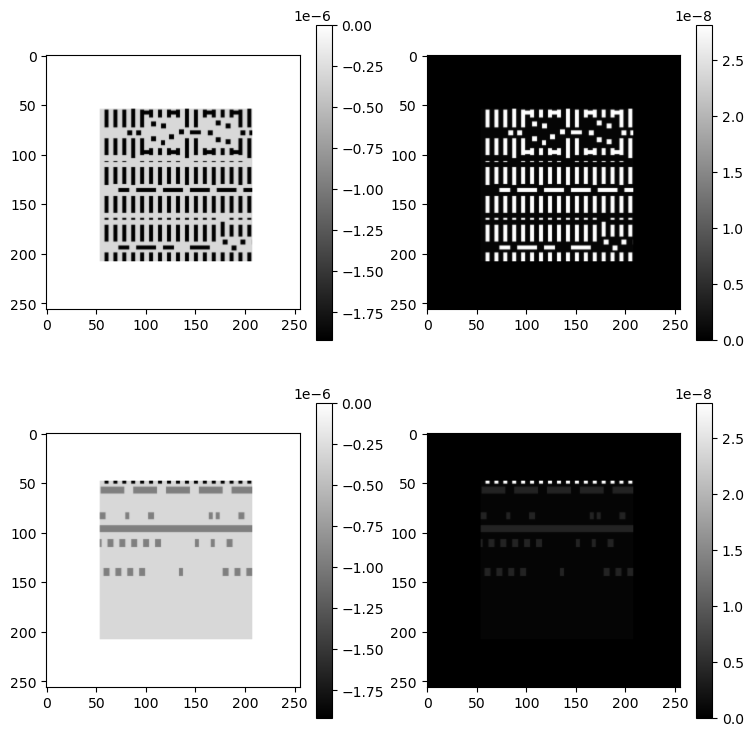

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[49+nz//2-256//2].real,cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(u[49+nz//2-256//2].imag,cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n//2].real,cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n//2].imag,cmap='gray')
fig.colorbar(im)

Note that in this formation delta is negative

## Create a solver class for tomography

In [6]:
tslv = holotomo.SolverTomo(theta, ntheta, nz, n, pnz, center)

note pnz parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pnz=nz. If the gpu does not have enough memory then pnz should  be decreased

## Create a solver class for holography

In [7]:
pslv = holotomo.SolverHolo(ntheta, nz, n, ptheta, voxelsize, energy, distances, norm_magnifications)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

In [8]:
Ru = tslv.fwd_tomo_batch(u)

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

In [9]:
psi = pslv.exptomo(Ru)

import random
shifts = np.zeros([ntheta,2],dtype=np.int32)
for k in range(ntheta):
    shift_x = random.randrange(-8,9)
    shift_y = random.randrange(-8,9)
    shifts[k,0] = shift_y
    shifts[k,1] = shift_x
shifts[:]=0
np.save('shifts.npy',shifts)
for k in range(ntheta):
    psi[k] = np.roll(psi[k],(shifts[k,0],shifts[k,1]),axis=(0,1))


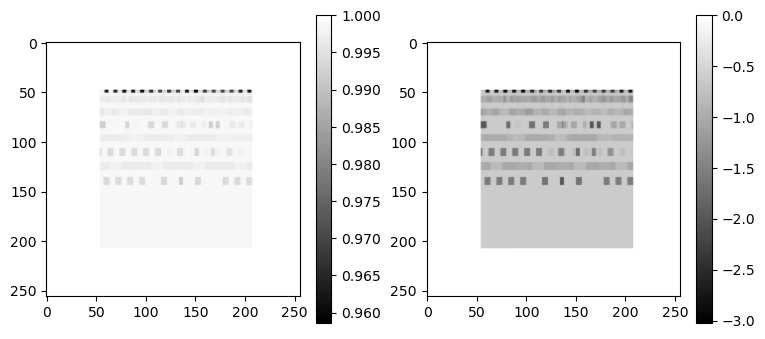

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
fig.colorbar(im)

## Read reference images (probes) recovered by the NFP (Near-field ptychogarphy) method at ID16A. There are probes for 4 different distances.

In [11]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0]
prb0 = np.zeros([ncodes,nz,n],dtype='complex64')
prb0[:] = prb_abs*np.exp(1j*prb_phase)  

# Structured illumination

ill_feature_size=1.28e-06m
(1, 256, 256, 256)


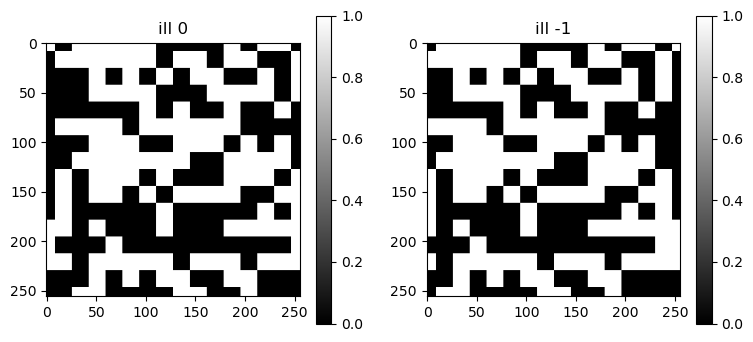

In [12]:
import random
import scipy.ndimage as ndimage
nill = n//16
ill_feature_size = n/nill*voxelsize

print(f'{ill_feature_size=}m')

ill0 = np.zeros([nill*nill],dtype=np.int32)
ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
ill0[ill_ids] = 1
ill0 = ill0.reshape(nill,nill)
ill = np.zeros([ncodes,ntheta,nill,nill],dtype=np.int32)
for k in  range(ill.shape[0]):
    for j in  range(ill.shape[1]):
        shift_x = random.randrange(-3,4)
        shift_y = random.randrange(-3,4)
        ill00 = np.roll(ill0,(shift_y,shift_x),axis=(0,1))
        ill[k,j] = ill00
ill = ndimage.zoom(ill,[1,1,n/nill,n/nill],order=0)
print(ill.shape)


fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(ill[0,0],cmap='gray')
axs[0].set_title('ill 0')
fig.colorbar(im)
im=axs[1].imshow(ill[0,-1],cmap='gray')
axs[1].set_title('ill -1')
fig.colorbar(im)



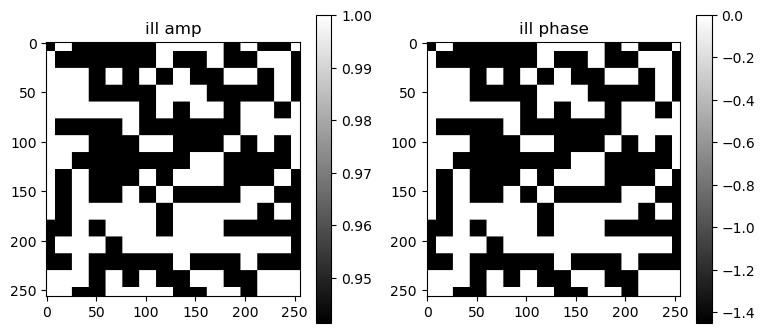

In [13]:
import xraylib
delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
thickness = 3*1e-6/voxelsize # thickness in pixels
# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / pslv.wavelength()).astype('complex64')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0,0]),cmap='gray')
axs[0].set_title('ill amp')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0,0]),cmap='gray')
axs[1].set_title('ill phase')
fig.colorbar(im)

In [14]:
prb = np.zeros([ncodes,ntheta,nz,n],dtype='complex64')
# prb = prb0[:,np.newaxis]*psiill
prb[:] = 1#psiill#prb0[:,np.newaxis]#*psiill

# Compute holographic projections for all angles and all distances

In [15]:
fpsi = pslv.fwd_holo_batch(psi,prb)

# fx = np.fft.fftshift(np.fft.fftfreq(n,d=voxelsize))
# [fx,fy] = np.meshgrid(fx,fx)
# for i,d in enumerate(distances):
#     fP = np.exp(-1j*np.pi*pslv.wavelength()*0.01*(fx**2+fy**2))

# ff = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(psi)))
# ff = ff*fP
# ff = np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(ff)))
# fpsi = ff[np.newaxis]
data = np.abs(fpsi)**2

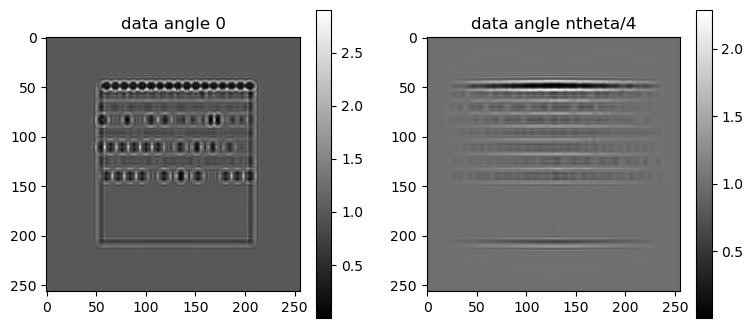

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(data[0,0],cmap='gray')
axs[0].set_title('data angle 0')
fig.colorbar(im)
im=axs[1].imshow(data[0,ntheta//4],cmap='gray')
axs[1].set_title('data angle ntheta/4')
fig.colorbar(im)

# Save data and probes

In [17]:
for k in range(ncodes):
    dxchange.write_tiff(data[k],f'/data/modeling/data_{n}_{k}',overwrite=True)
    dxchange.write_tiff(np.abs(prb[k]),f'/data/modeling/prb_amp_{n}_{k}',overwrite=True)
    dxchange.write_tiff(np.angle(prb[k]),f'/data/modeling/prb_angle_{n}_{k}',overwrite=True)
    dxchange.write_tiff(np.abs(psi),f'/data/modeling/psi_amp_{n}',overwrite=True)
    dxchange.write_tiff(np.angle(psi),f'/data/modeling/psi_angle_{n}',overwrite=True)